# PrimalCore quick start



## Building a Catalog

Download the catalog:

* wget http://isdc.unige.ch/~tramacer/stuff/euclid_cosmos_DC2_S2_v2.1_calib.fits.gz


In [1]:
from PrimalCore.heterogeneous_table.table import Table


In [2]:
ph_catalog='./euclid_cosmos_DC2_S2_v2.1_calib.fits.gz'

In [3]:
    catalog=Table.from_fits_file(ph_catalog,fits_ext=1)

| input data built
| data Rows,Cols 198435 124


the catalog has been built. 

### Catalog preprocessing

Since we have a large number of columns (124) and we are not interested in all of them, we can keep only the needed ones.  

We use the ``keep_columns`` method:

In [4]:
catalog.keep_columns(['FLUX*2','FLUX_VIS','reliable_S15','STAR','AGN','MASKED','FLAG_PHOT','z_spec_S15'],regex=True)

As a further step of the catalog preprocessing we make a cut to select clean entries:  ``CLEAN=" (FLAG_PHOT == 0) & (MASKED == 0) & (STAR == 0) & (AGN == 0)& (reliable_S15==1)"``

In [5]:
CLEAN= (catalog.data['FLAG_PHOT']==0)*(catalog.data['MASKED']==0)*(catalog.data['STAR']==0)
CLEAN*=(catalog.data['AGN']==0)*(catalog.data['reliable_S15']==1)
catalog.keep_rows(CLEAN)

| filtering data rows
| data initial Rows,Cols= (198435,)
| data filtered Rows,Cols= (13252,)



The number of rows has decreased.

## Building a ML DataSet

In [6]:
from PrimalCore.homogeneous_table.dataset import MLDataSet
from PrimalCore.homogeneous_table.dataset_handler import drop_features
from PrimalCore.homogeneous_table.dataset_handler import keep_features
from PrimalCore.homogeneous_table.dataset_handler import add_features

In [7]:
dataset=MLDataSet.new_from_table(catalog,target_col_name='z_spec_S15',target_bins=20,target_binning='log',catalog_file=ph_catalog)

| building features
| features built
| Rows,Cols 13252 20


since our target variableit is a contineous variable, the stratified sampling might fail. Setting target_bins, a binning is performed with a number of bins equal to target_bins. Each entry will have a label given by the bin ID. the target_binning parameter sets the binning strategy to logarithmic

## DataSet preprocessing

### Features preprocessing: adding flux ratios

In [8]:
from PrimalCore.phz_tools.photometry import FluxRatio

In [9]:
flux_bands_list_2=['FLUX_G_2','FLUX_R_2','FLUX_I_2','FLUX_Z_2','FLUX_Y_2','FLUX_J_2','FLUX_VIS','FLUX_VIS','FLUX_VIS']
flux_bands_list_1=['FLUX_R_2','FLUX_I_2','FLUX_Z_2','FLUX_Y_2','FLUX_J_2','FLUX_H_2','FLUX_Y_2','FLUX_J_2','FLUX_H_2']

In [10]:
for f1,f2 in zip(flux_bands_list_1,flux_bands_list_2):
    f1_name=f1.split('_')[1]
    f2_name=f2.split('_')[1]
    if f1 in dataset.features_names and f2 in dataset.features_names:
        f=FluxRatio('F_RATIO_%s'%(f2_name+'-'+f1_name),f1,f2,features=dataset)
        add_features(dataset,f.name,f.values)

### Features preprocessing: selecting features and adding weights

We can decide to keep only columns  with **Flux** and **FluxRatio** information.

In [11]:
keep_features(dataset,['FLUX*','F_RATIO*'],regex=True)

| features initial Rows,Cols= 13252 29
| removing features ['FLAG_PHOT', 'MASKED', 'reliable_S15', 'STAR', 'AGN']
| features final Rows,Cols= 13252 24



In [12]:
dataset.features_names

['FLUX_G_2',
 'FLUX_R_2',
 'FLUX_I_2',
 'FLUX_VIS',
 'FLUX_Z_2',
 'FLUX_Y_2',
 'FLUX_J_2',
 'FLUX_H_2',
 'FLUXERR_G_2',
 'FLUXERR_R_2',
 'FLUXERR_I_2',
 'FLUXERR_Z_2',
 'FLUXERR_Y_2',
 'FLUXERR_J_2',
 'FLUXERR_H_2',
 'F_RATIO_G-R',
 'F_RATIO_R-I',
 'F_RATIO_I-Z',
 'F_RATIO_Z-Y',
 'F_RATIO_Y-J',
 'F_RATIO_J-H',
 'F_RATIO_VIS-Y',
 'F_RATIO_VIS-J',
 'F_RATIO_VIS-H']

In [13]:
from PrimalCore.heterogeneous_table.tools import build_names_list

flux_name_list=build_names_list('FLUX_*_2',dataset.features_names,regex=True)
flux_err_name_list=build_names_list('FLUXERR_*_2',dataset.features_names,regex=True)



dataset.weight_array=1.0/dataset.get_feature_by_name('FLUXERR_J_2')

In [14]:
dataset.weight_array

array([ 4.49985677,  3.67068885,  2.62369698, ...,  3.99935633,
        3.16386988,  3.26524177])

## Model Training

### Train/Test splitting

We split the dataset into train and test, using a shuffling with stratified sampling. 

In [15]:
from PrimalCore.preprocessing.dataset_preprocessing import dataset_train_test_split

In [16]:
train,test=dataset_train_test_split(dataset,train_ratio=0.2,stratify=True)
print train.features_N_rows, test.features_N_rows

2650 10602


The plot below shows that the redsfhit distributions for the full, the training, and the test set are similar thanks to the stratification. 

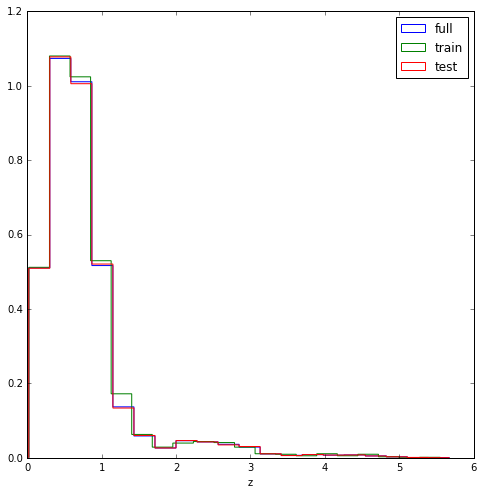

In [17]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize']=8,8

plt.hist(dataset.target_array,bins=20,histtype='step',normed=True,label='full')
plt.hist(train.target_array,bins=20,histtype='step',normed=True,label='train')
plt.hist(test.target_array,bins=20,histtype='step',normed=True,label='test')
plt.xlabel('z')
plt.legend()
plt.show()

### Running an AdaBost regression

We use the :class:`PrimalCore.models.regression.Regressor`, and the class method  `AdaBoostRegressor`

In [18]:
from PrimalCore.models.regression import Regressor

In [19]:
ada_boost_model=Regressor.ABRegressor(n_estimators=50)

To train our model we call the fit method

In [20]:
ada_boost_model.clf.fit(train.features,train.target_array)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)

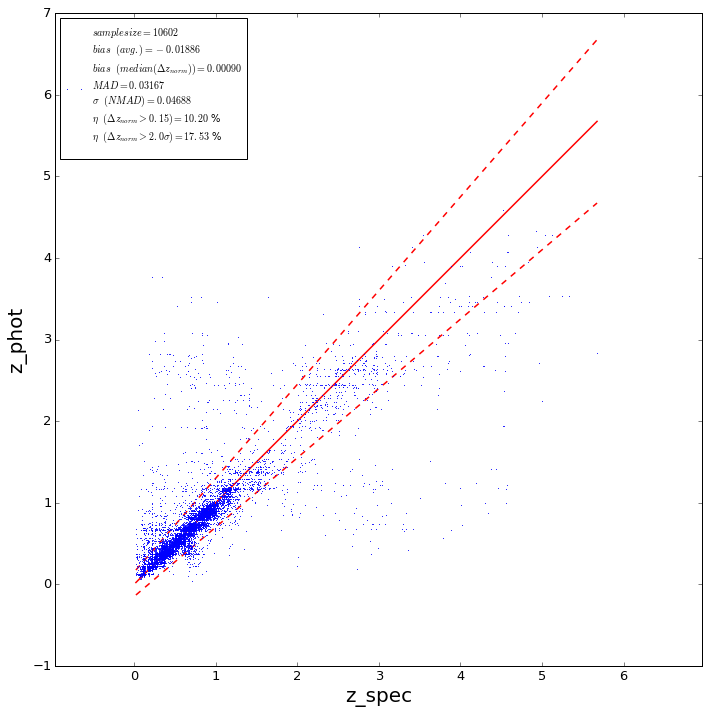

In [21]:
from PrimalInteractive.plotting.phz_plots import plot_z_spec_vs_z_phot

plt.rcParams['figure.figsize']=10,10

z_spec=test.target_array
z_phot=ada_boost_model.clf.predict(test.features)

prima_plot=plot_z_spec_vs_z_phot(z_spec,z_phot,plot=True)

/Users/orion/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


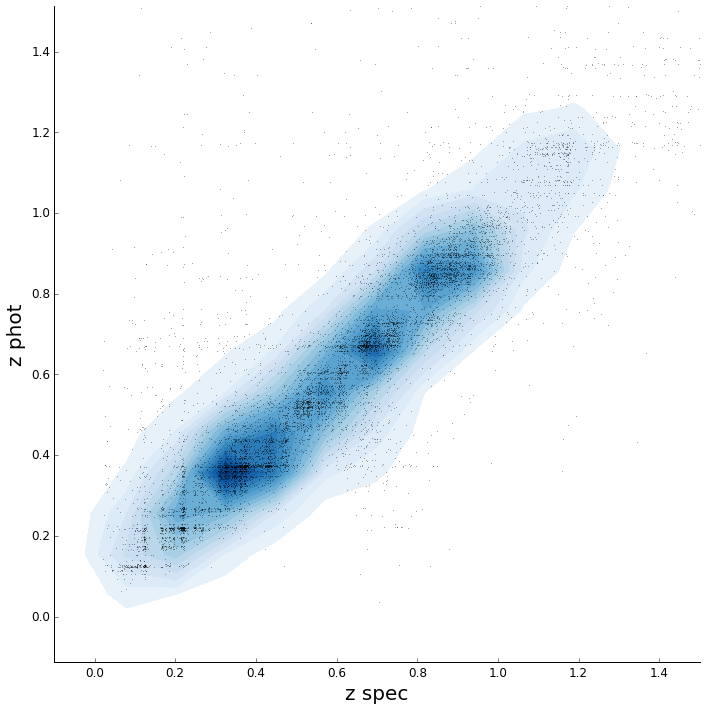

In [22]:
from PrimalInteractive.plotting.phz_plots import plot_z_spec_vs_z_phot_kde

prima_plot=plot_z_spec_vs_z_phot_kde(z_spec,z_phot,plot=False,gridsize=50,n_levels=20)
prima_plot.ax.set_ylim(-0.1,1.5)
prima_plot.ax.set_xlim(-0.1,1.5)
plt.show()

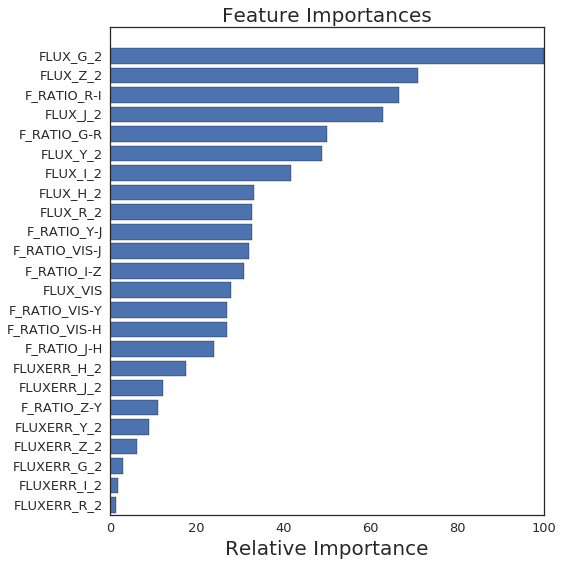

In [23]:
from PrimalInteractive.plotting.phz_plots import plot_features_imp
plt.rcParams['figure.figsize']=8,8

feat_imp=ada_boost_model.feature_importances(feature_names=train.features_names)
prima_plot=plot_features_imp(feat_imp['score'],feature_names=feat_imp['name'],plot=True)

## Model Recursive features elimination
To understand if we need all the features, we can perform a recursive feature elimination.

In [24]:
from PrimalCore.preprocessing.features_selection import rec_feat_rem_cv
from PrimalCore.phz_tools.stats import outliers_score
initial_feat_num=train.features_N_cols
support,n_features,scores,ranking=rec_feat_rem_cv(ada_boost_model,train,cv=5,scoring=outliers_score,filter=True)

Optimal number of features : 22


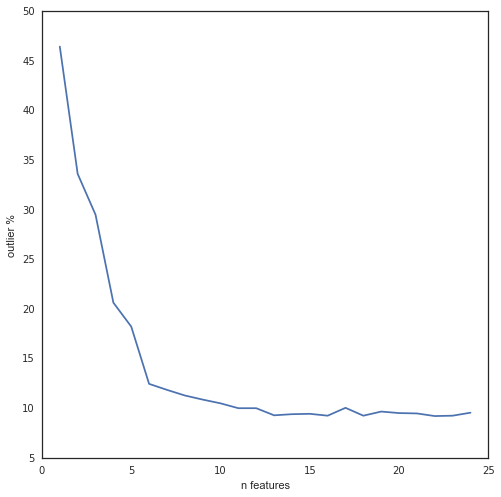

In [25]:
plt.plot(np.arange(initial_feat_num)+1,100.0-scores)
plt.xlabel('n features')
plt.ylabel('outlier %')
plt.show()

The highest score, i.e. the lowest fractio of outliers is obtained for 17 features
We can now rerun the training with the reduced fetures set. By passing the filter=True parameter, the features are automatically removed from the train dataset.

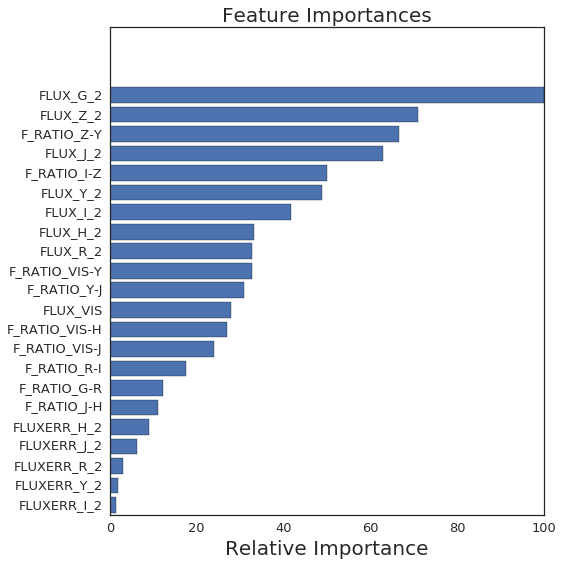

In [26]:
plt.rcParams['figure.figsize']=8,8

feat_imp=ada_boost_model.feature_importances(feature_names=train.features_names)
ax=plot_features_imp(feat_imp['score'],feature_names=feat_imp['name'],plot=True)

We train again our model with the reduced number of features

In [27]:
ada_boost_model.clf.fit(train.features,train.target_array)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)

In [28]:
test.columns_mask=support
print test.columns_mask
print train.columns_mask

[ True  True  True  True  True  True  True  True False  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True False  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True]


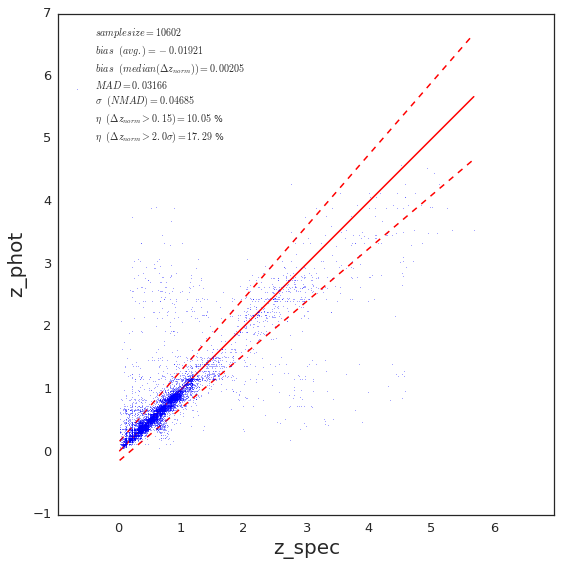

In [29]:
z_spec=test.target_array
z_phot=ada_boost_model.clf.predict(test.features)

prima_plot=plot_z_spec_vs_z_phot(z_spec,z_phot,plot=True)
plt.rcParams['figure.figsize']=10,10

## Entries selection based on clean cut

We can check if after the clean cut we still have objects with 'wrong' values, i.e. negative fluxes

In [30]:
from PrimalCore.heterogeneous_table.tools import build_names_list

flux_name_list=build_names_list('FLUX_*_2',dataset.features_names,regex=True)
msk=np.ones(dataset.features_N_rows,dtype=np.bool)

In [31]:
msk=np.ones(dataset.features_N_rows,dtype=np.bool)

for f in flux_name_list:
    msk*=dataset.get_feature_by_name(f)>0

finally we filter the rows, using two methods:
    * dropping
    * masking 

since the dropping will modify the dataset features shape, we create a copy

In [32]:
import copy
original_dataset=copy.deepcopy(dataset)

### dropping 


In [33]:
from PrimalCore.homogeneous_table.dataset_handler import keep_rows
print 'rows befor cut',dataset.features_N_rows
keep_rows(dataset,msk)
print 'rows after cut',dataset.features_N_rows

rows befor cut 13252
rows after cut 12995


### masking

In [34]:
original_dataset.rows_mask=msk
print original_dataset.features_N_rows

13252


In [35]:
print original_dataset.features.shape

(12995, 24)


We retrain our molde, and plot the results for the new predictions

We apply the mask both to the train and test set

In [36]:
flux_name_list=build_names_list('FLUX_*_2',train.features_names,regex=True)

msk=np.ones(train.features_N_rows,dtype=np.bool)

for f in flux_name_list:
    msk*=train.get_feature_by_name(f)>0
train.rows_mask=msk
    
msk=np.ones(test.features_N_rows,dtype=np.bool)
for f in flux_name_list:
    msk*=test.get_feature_by_name(f)>0
test.rows_mask=msk

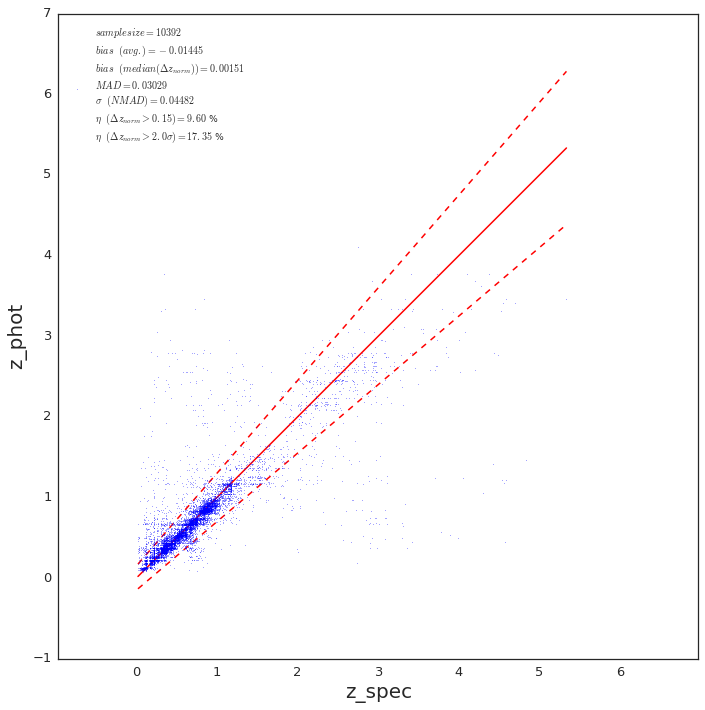

In [37]:
ada_boost_model.clf.fit(train.features,train.target_array)
z_phot=ada_boost_model.clf.predict(test.features)
z_spec=test.target_array

prima_plot=plot_z_spec_vs_z_phot(z_spec,z_phot,plot=True)

## PDF


In [38]:
from PrimalCore.pdf.tools import extract_pdf
pdf_matrix=extract_pdf(ada_boost_model, test,gmm_components=2)

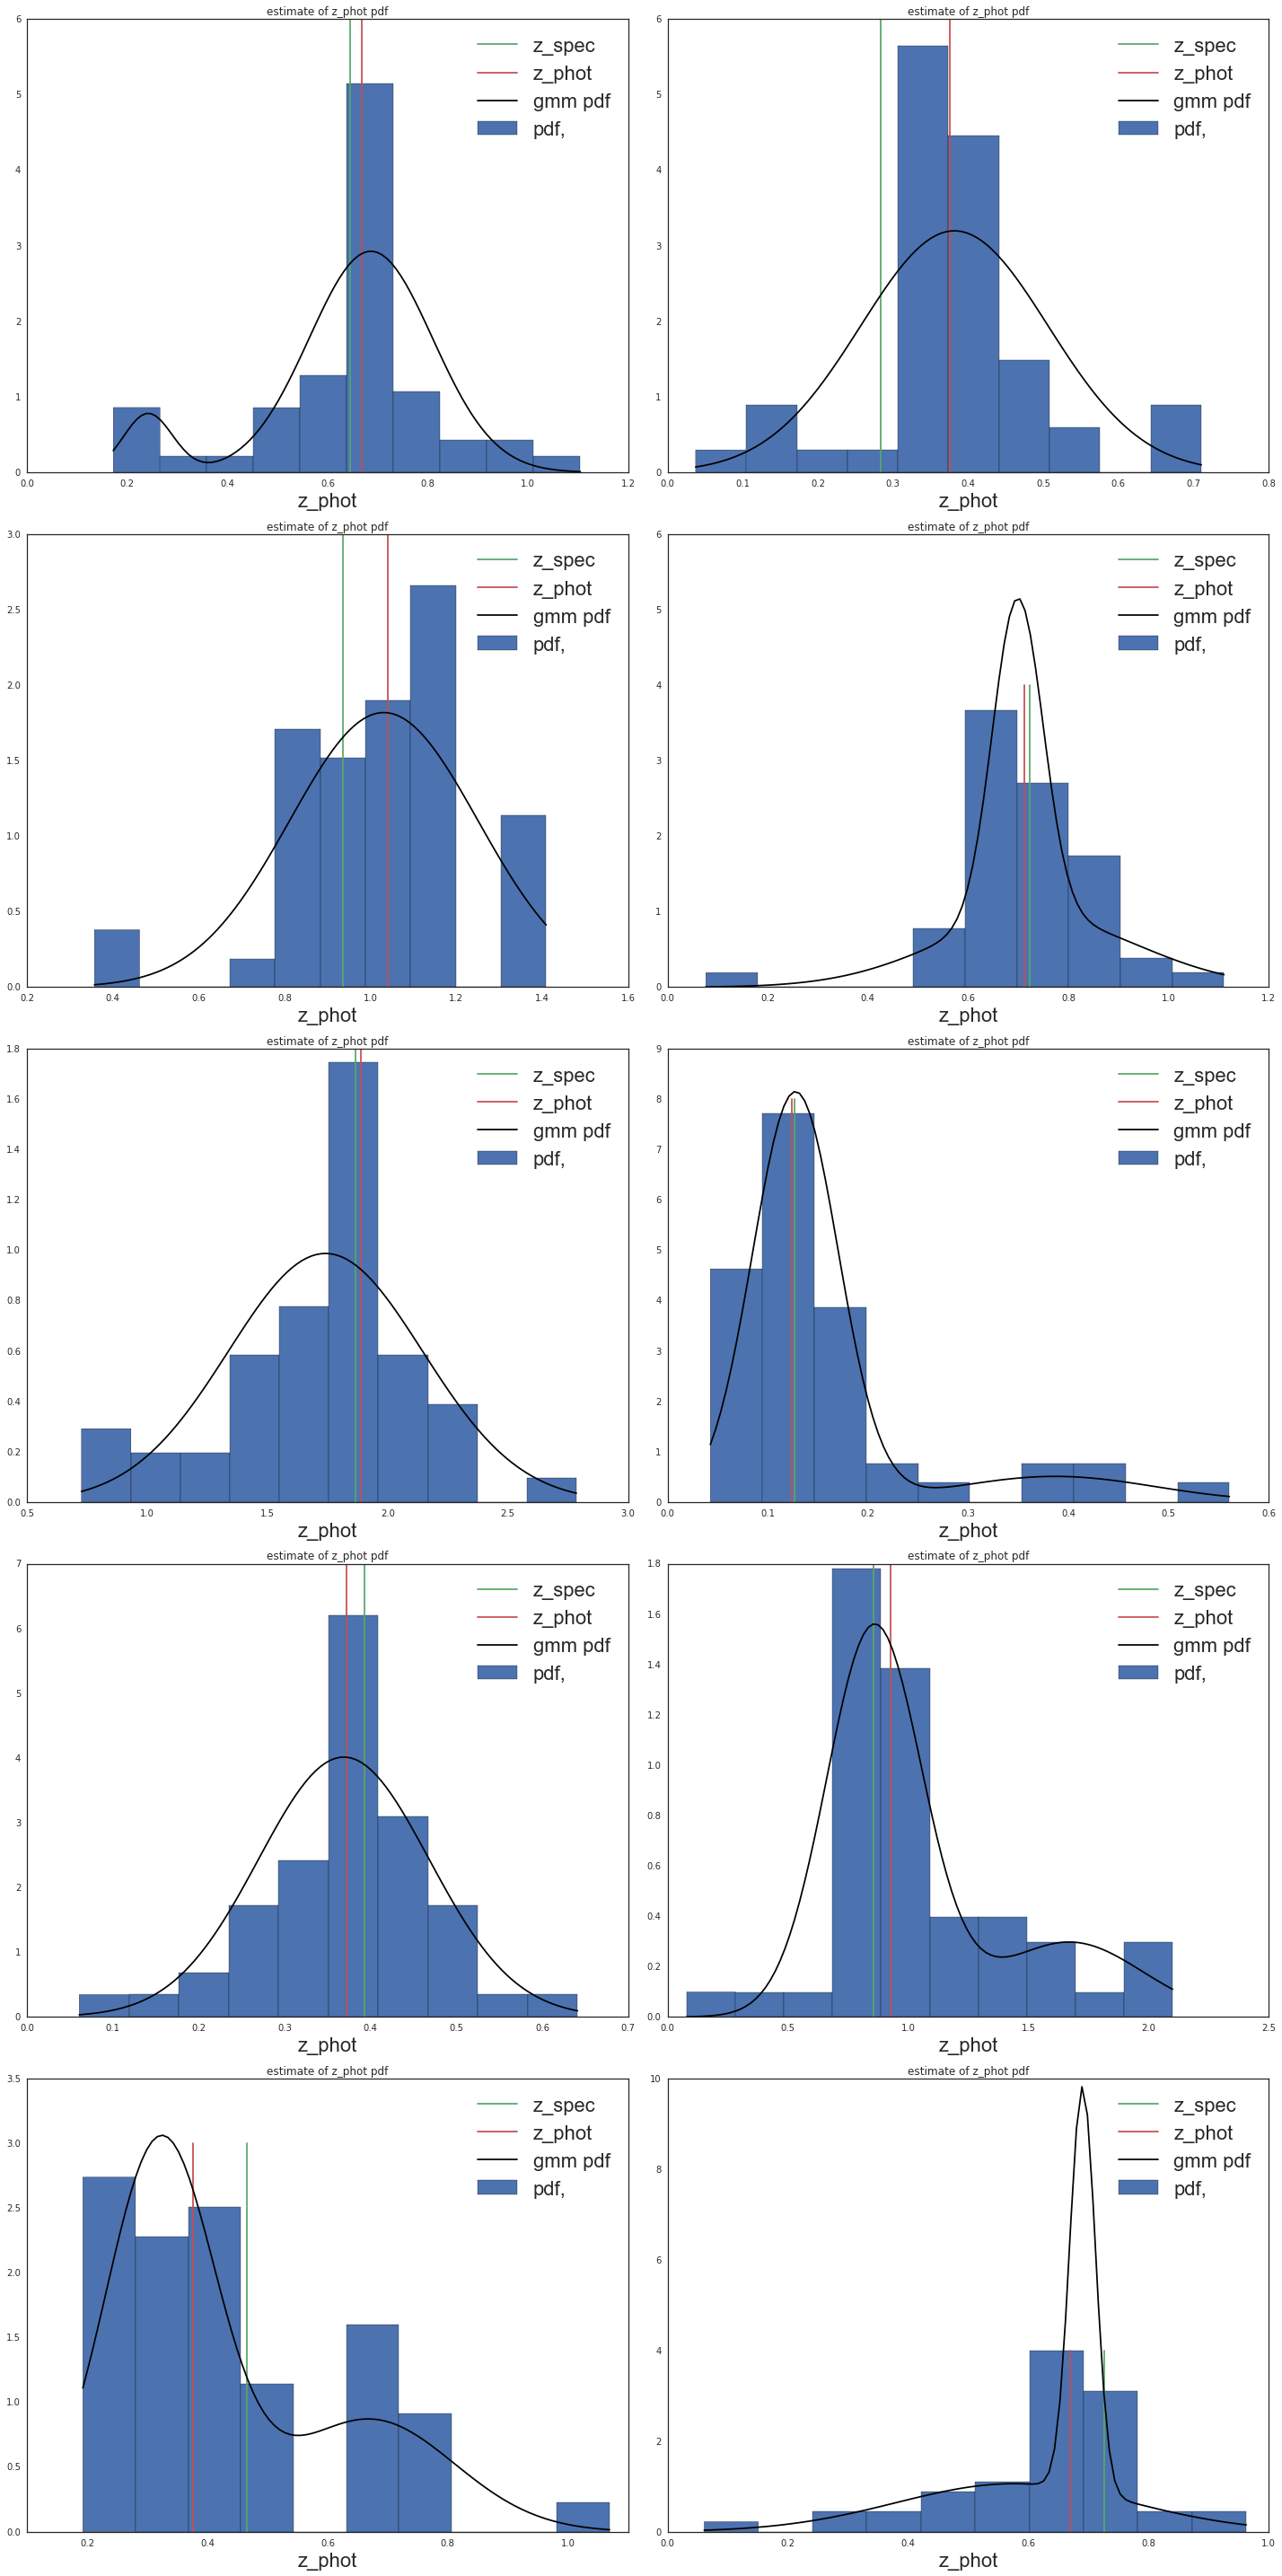

In [39]:
from PrimalInteractive.plotting.phz_plots import plot_pdf

n_cols=2
n_rows=5
plt.rcParams['figure.figsize']=10*n_cols,8*n_rows
fig1,axs=plt.subplots(n_rows,n_cols)
for ID,ax in enumerate(axs.flatten()):
    plot_pdf(pdf_matrix,ID,plot=True,ax=ax,bins=10)
plt.tight_layout()

In [40]:
from PrimalCore.pdf.stats import eval_pit,eval_crps
from PrimalInteractive.plotting.phz_plots import plot_PIT_histogram,plot_pdf,plot_CRPS_histogram

preds = ada_boost_model.eval_estimators_predictions(test.features)

pit = eval_pit(pdf_matrix['z_phot_values'], pdf_matrix['z_spec'])
cprs = eval_crps(pdf_matrix['z_phot_values'],pdf_matrix['z_spec'])

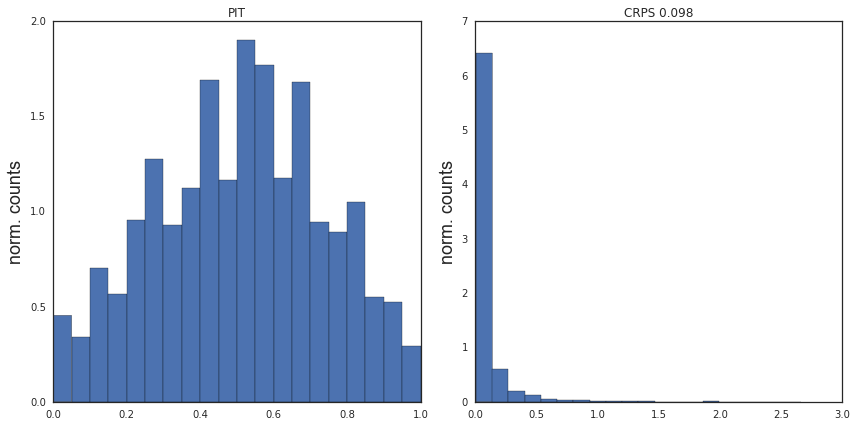

In [62]:
plt.rcParams['figure.figsize']=12,6

fig1,(ax1,ax2)=plt.subplots(1,2)

plot_PIT_histogram(pit, ax=ax1)
plot_CRPS_histogram(cprs, ax=ax2)

## Saving predictions 


In [42]:
data=ada_boost_model.save_mldataset_predictions('test_prediction.fits',test)

/Users/orion/anaconda/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'test_prediction.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


## Post trainig analysis

In this section we show a possible post-training analysis, where we work a the saved prediction file.

We load the prediction file for the test set

In [43]:
data,h=pf.getdata('test_prediction.fits',header=True)

We get the information for the original spectroscopic catalog

In [44]:
catalog_file=h.get('cat_file')

We load the catalog

In [45]:
from PrimalCore.heterogeneous_table.table import Table

catalog=Table.from_fits_file(catalog_file,fits_ext=1)

| input data built
| data Rows,Cols 198435 124


Thank to the stored ``original_entry_ID`` field we can match any entry in test set results file to the original spectroscopic dataset, and for example check of the magnitude value (not used in the training) impacts on the 
error on the predicted redshift 

In [46]:
delta=np.fabs((data['actual']-data['pred']))/data['actual']
from PrimalCore.heterogeneous_table.tools import build_names_list
x_name_list=build_names_list('MAG_*',catalog.column_names,regex=True)

/Users/orion/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/orion/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/orion/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/orion/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/orion/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/orion/anaconda/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarnin

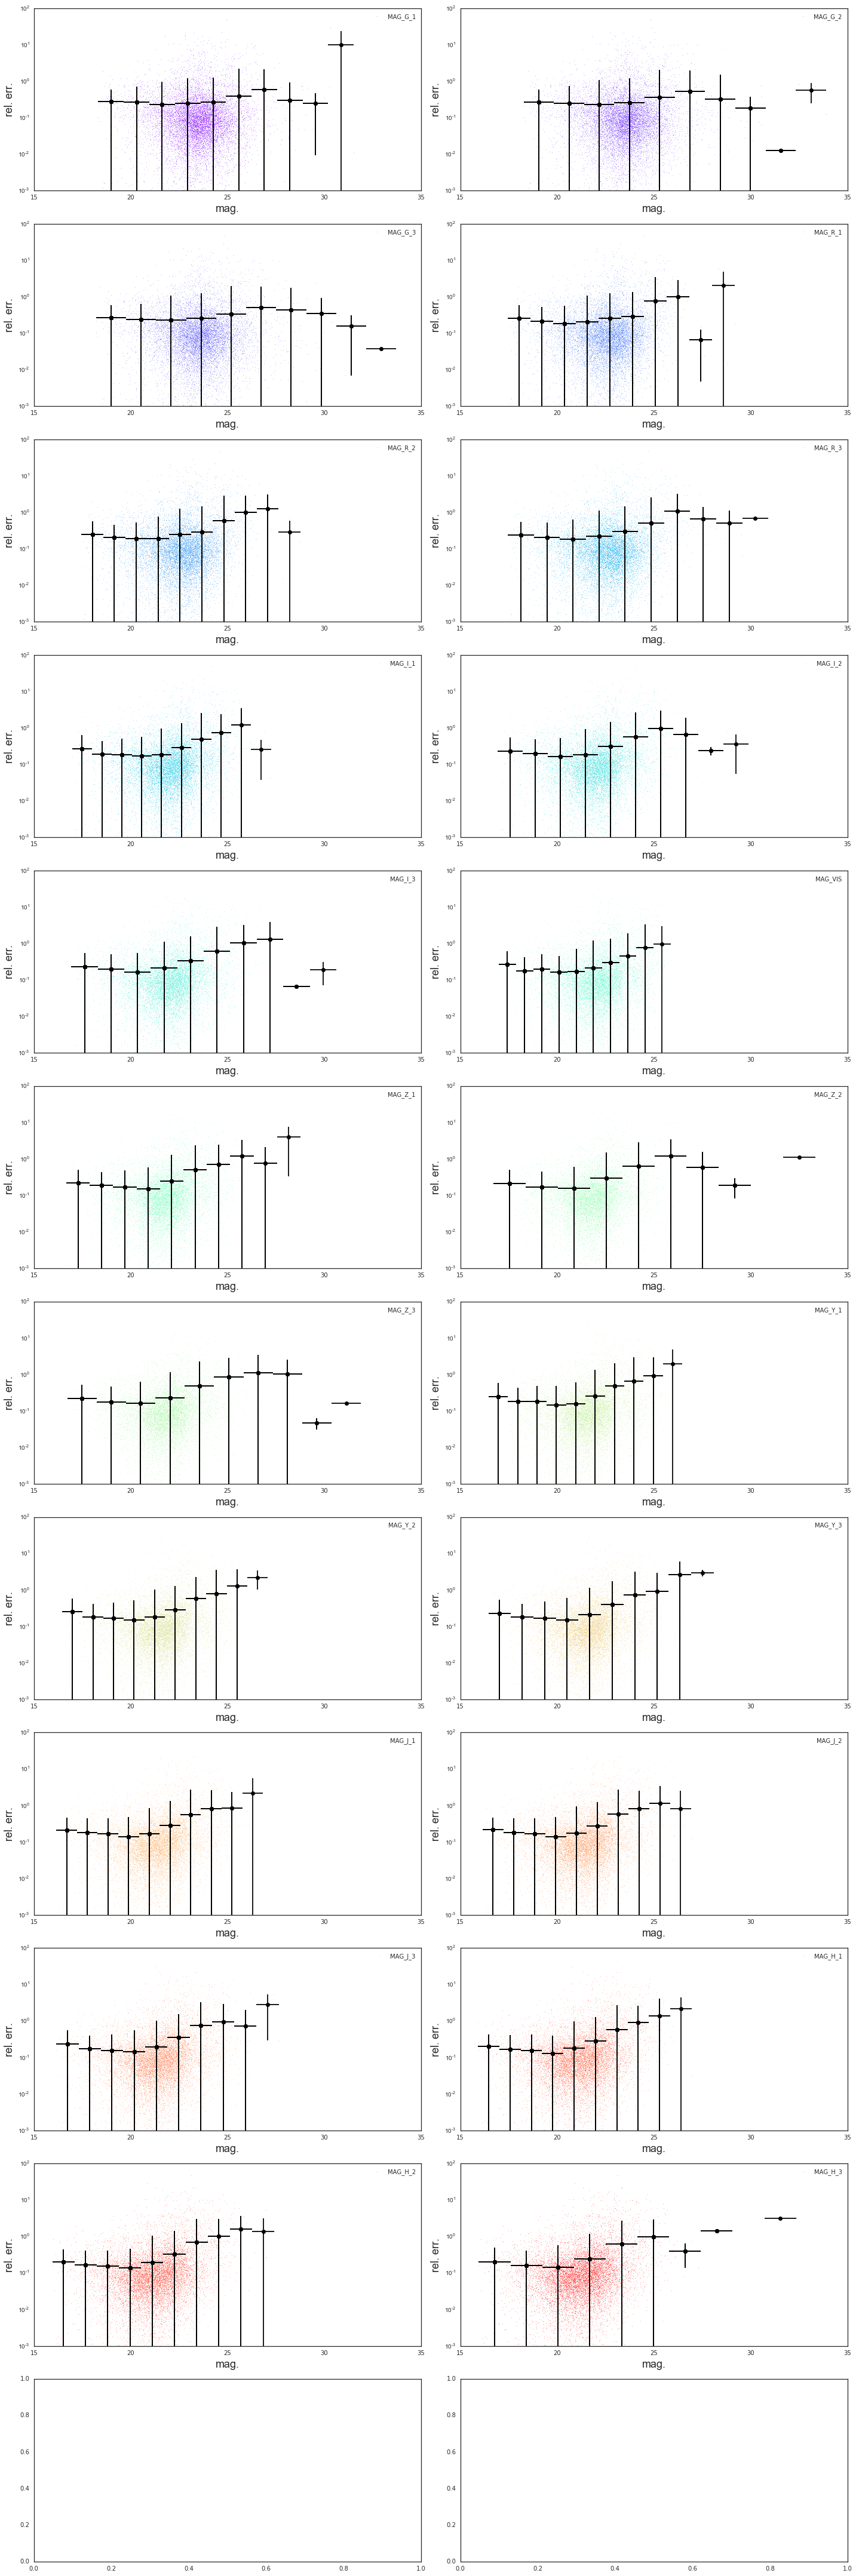

In [47]:
from PrimalInteractive.plotting.phz_plots import binned_trend_scatter_plot

from matplotlib.pyplot import cm 
%matplotlib inline
n_cols=2
n_rows=len(x_name_list)/2+1
plt.rcParams['figure.figsize']=10*n_cols,5*n_rows
color=iter(cm.rainbow(np.linspace(0,1,len(x_name_list))))
fig,ax=plt.subplots(n_rows,n_cols)

for a,x_name in zip(ax.flatten(),x_name_list):
    x=catalog.data[x_name][data['original_entry_ID']]
    
    msk=x>15
    #msk*=x<.2
   
    p=binned_trend_scatter_plot(x[msk],delta[msk],x_label='mag.',y_label='rel. err.',ax=a,color=next(color),label=x_name)
    a.set_xlim(15,35)
    a.set_yscale("log")
    a.set_ylim(0.001,100.)

plt.tight_layout()
plt.show()